We are intersted in the following network metrics:
- clustering degree
- clustering coefficient
- path length: average distance (shortest path) from each node to any other node.
- small-world networks: charactrized by higher clustering coefficient and lower path length than random networks. Small-worldedness can be measured using the following metrics:
    - $\sigma = {{C / C_r} \over {L / L_r}}$, where $r$ refers to a random network. A graph is classified as small-world if $\sigma>1$.
    - $\omega = L_r/L - C/C_l$, where $l$ refers to a lattice network and r refers to a random network. $\omega$ ranges between -1 (lattice) and 1 (random). A graph features small-world characteristics if $\omega$ is close to 0.

    - statistical significance of small-world features.

**Note from Cohen (2014; p442):**
simulate C and L with regard to the probability of rewiring from low to high (regular to random). See figure 31.13.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks')

import networkx as nx

In [2]:
project_dir = '../..'

# data
conn_data = pd.read_csv(f'{project_dir}/outputs/julia2018_mean_resting_connectome.tsv',
                        index_col=0, sep='\t')
labels = conn_data.columns.values.tolist()
conn = conn_data.values


## Dosenbach2007, Figure 7

Network of task control ROIs features a small-world network property that can be distinguished from random networks or a regular lattice. Here, we test the alternative hypothesis that task control nodes form a small-world network.

But first, let's reproduce the figure 7 from Dosenbach2007. This figure compares task control network to random and regular networks while applying different binarization thresholds.

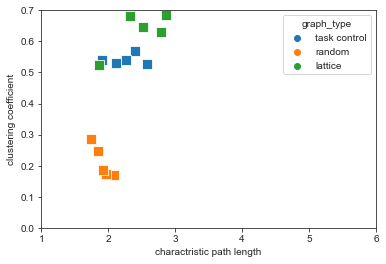

In [6]:
# params
thresholds = [0.2, 0.175, 0.15, 0.125, 0.1]

def _network_measures(G, r, graph_type):
    network_measures = []
    for g in [G.subgraph(c) for c in nx.connected_components(G) if len(c)>4]:
        C = nx.average_clustering(g)
        L = nx.average_shortest_path_length(g)
        # print(f'average clustering coefficient (C): {C}')
        # print(f'average shortest path length (L): {L}')

        network_measures.append((graph_type, r, C, L))
        # sw_sigma = nx.smallworld.sigma(g) # must be > 1
        # sw_omega = nx.smallworld.omega(g) # must be close to 0
        # print(f'Small-world Sigma (>1): {sw_sigma}')
        # print(f'Small-world Omega (~0): {sw_omega}')
    return network_measures[0]

measures = [] # list of ('graph_type', r, Cp, Lp)
for r in thresholds:
    bin_conn = (conn>=r).astype('int')
    Gp = nx.from_numpy_matrix(bin_conn)                    # small-world (task control)
    Gr = nx.smallworld.random_reference(Gp, niter=100)     # random
    Gl = nx.smallworld.lattice_reference(Gp, niter=100)    # lattice

    measures.append(_network_measures(Gp, r, 'task control'))
    measures.append(_network_measures(Gr, r, 'random'))
    measures.append(_network_measures(Gl, r, 'lattice'))

# nx.draw_spring(G, node_size=400)
measures = pd.DataFrame(measures, columns=['graph_type','r','C','L'])

# Dosenbach2007 / Figure 7
fig, ax = plt.subplots(1,1)
sns.scatterplot(data=measures, x='L', y='C', ax=ax, hue='graph_type', marker='s', s=100)
ax.set(xlim=(1,6), ylim=(0,.7), xlabel='charactristic path length', ylabel='clustering coefficient')

plt.show()

## Cohen (2014), Chapter 31

### Replicating figure 31.11
The effect of binarization on the network structure can be seen by a plot that illusterates the relationship between clustering coefficient (C) and thresholding factor (r).

In the plot below, gray lines correspond to each ROI and the black line correspond to the average clustering coefficient accross all ROIs.

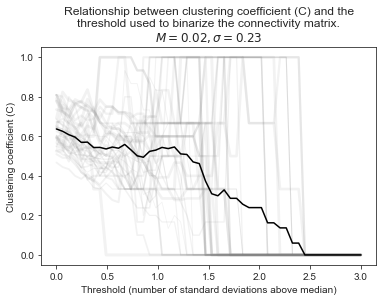

In [71]:
CCs = []
conn_median = np.median(conn)
conn_std = np.std(conn)
xs = np.linspace(0.0, 3.0, 50)
for x in xs:
    r = conn_median + x * conn_std
    bin_conn = (conn>=r).astype('int')
    Gp = nx.from_numpy_matrix(bin_conn)                    # small-world (task control)
    for i,n in enumerate(labels):
        Ci = nx.average_clustering(Gp,nodes=[i])
        CCs.append((i,x,r,Ci))

plot_data = pd.DataFrame(CCs, columns=['node','std_step','r','C'])

fig, ax = plt.subplots(1,1)

sns.lineplot(data=plot_data, x='std_step', y='C', size='node',alpha=.1, ax=ax,color='gray',legend=None)
sns.lineplot(x=plot_data['std_step'].unique(), y=plot_data.groupby('std_step').mean()['C'],alpha=1,color='black', ax=ax)
ax.set(xlabel='Threshold (number of standard deviations above median)',
       ylabel='Clustering coefficient (C)',
       title=f'Relationship between clustering coefficient (C) and the\nthreshold used to binarize the connectivity matrix.\n$M={conn_median:.2f}, \sigma={conn_std:.2f}$')
plt.show()

### Cohen2014: Replicating figure 31.14

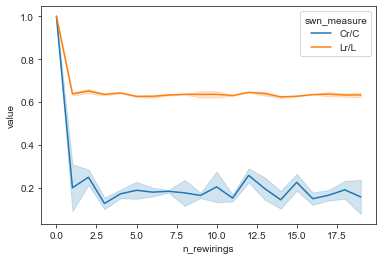

In [26]:
conn_data_no_vmPFC = conn_data.drop(columns=['vmPFC'])
conn_data_no_vmPFC = conn_data_no_vmPFC.drop(index=['vmPFC'])

labels_no_vmPFC = conn_data_no_vmPFC.columns.values.tolist()
conn_no_vmPFC = conn_data_no_vmPFC.values

r = np.median(conn_no_vmPFC) + np.std(conn_no_vmPFC)
bin_conn = (conn_no_vmPFC>=r).astype('int')
Gp = nx.from_numpy_matrix(bin_conn)                    # small-world (task control)


def simulate_swn(G, n):
    _swns = []
    for i in range(n):
        sigma = nx.smallworld.sigma(g, niter=1, nrand=1)
        # omega = nx.smallworld.omega(g) # must be close to 0
        _swns.append((sigma))
    return _swns

swns = []
for n_rewirings in range(20):
        measures.append(simulate_rewiring(Gp, n_rewirings))


plot_data = pd.DataFrame(measures, columns=['n_rewirings','Cr/C','Lr/L'])
plot_data = plot_data.melt(id_vars=["n_rewirings"], var_name="swn_measure", value_name="value")

sns.lineplot(data=plot_data,x='n_rewirings',y='value',hue='swn_measure')
plt.show()

### Cohen2014: Replicating permutation testing (figure 31.16)

- threshold as X, and Z-scored small-world-ness as Y
- test the statistical significance of the small-world-ness of the network using permutations.

In [73]:
# parameters
n_simulations = 10
r = np.median(conn_no_vmPFC) + np.std(conn_no_vmPFC)

# data
conn_data_no_vmPFC = conn_data.drop(columns=['vmPFC'])
conn_data_no_vmPFC = conn_data_no_vmPFC.drop(index=['vmPFC'])

labels_no_vmPFC = conn_data_no_vmPFC.columns.values.tolist()
conn_no_vmPFC = conn_data_no_vmPFC.values

# threshold and make a graph
bin_conn = (conn_no_vmPFC>=r).astype('int')
Gp = nx.from_numpy_matrix(bin_conn)


def simulate_swn(G, n):
    """simulates random network SWM for n times."""
    _swns = []
    for i in range(n):
        # step 1:
        Gr = nx.smallworld.random_reference(G, niter=10)
        # step 2:
        sigma = nx.smallworld.sigma(Gr, niter=1, nrand=10) # must be > 1
        # omega = nx.smallworld.omega(g) # must be close to 0

        _swns.append(sigma)
    return _swns

# perumated SWMs
simulated_swns = simulate_swn(Gp, 10)

# observed SWM
print('calculating observed swn...')
observed_swn = nx.smallworld.sigma(Gp, niter=1)

print(f'observed swn={observed_swn:.2f}')

calculating observed swn...
observed swn=3.40


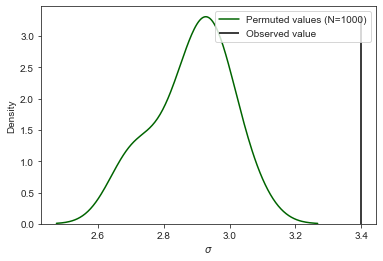

In [80]:
import scipy.stats as st

fig, ax = plt.subplots(1,1)

median_swm = st.kde.gaussian_kde(swns)(np.median(swns))

sns.kdeplot(swns,ax=ax,color='darkgreen')
ax.vlines(observed_swn,ymin=0,ymax=median_swm, color='black')
ax.set(xlabel='$\sigma$')

plt.legend(['Permuted values (N=1000)','Observed value'])
plt.show()

print()